## Import

In [1]:
import random
import pandas as pd
import numpy as np
import os
import re

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [3]:
CFG = {
    'X_RANGE':334, # 예측하려는 시점을 X_RANGE 만큼의 이전 일자의 데이터로부터 예측 및 학습
    'EPOCHS':3,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':128,
    'SEED':41
}

## Fixed RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load

In [5]:
train_df = pd.read_csv('./train.csv')

In [6]:
train_df

,일시,광진구,동대문구,성동구,중랑구
0,20180101,0.592,0.368,0.580,0.162
1,20180102,0.840,0.614,1.034,0.260
2,20180103,0.828,0.576,0.952,0.288
3,20180104,0.792,0.542,0.914,0.292
4,20180105,0.818,0.602,0.994,0.308
...,...,...,...,...,...
1456,20211227,3.830,3.416,2.908,2.350
1457,20211228,4.510,3.890,3.714,2.700
1458,20211229,4.490,3.524,3.660,2.524
1459,20211230,4.444,3.574,3.530,2.506


In [7]:
temporary = pd.DataFrame()

In [8]:
# import numpy as np
# from scipy import interpolate
# for loc in train_df.columns[1:]:
#     ans = []
#     for i in range(len(train_df)-1):
#         x = np.array(range(24))
#         y = np.linspace(train_df.loc[i,loc], train_df.loc[i+1,loc], 24)
#         sp = interpolate.interp1d(x,y,kind='cubic')

#         xs = np.linspace(x[0], x[-1], 24)
#         ys = sp(xs)
#         ys = list(ys)
#         ys.pop()
#         ans.extend(ys)
#     temporary[loc] = ans

In [9]:
# ans = []
# for i in range(len(train_df)-1):
#     x = np.array(range(24))
#     y = np.linspace(train_df.loc[i,'일시'], train_df.loc[i+1,'일시'], 24)
#     sp = interpolate.interp1d(x,y,kind='cubic')

#     xs = np.linspace(x[0], x[-1], 24)
#     ys = sp(xs)
#     ys = list(ys)
#     ys.pop()
#     ans.extend(ys)
# temporary['일시'] = ans
# temporary

In [10]:
# len(train_df)*23-23

In [11]:
# train_df = temporary

## Data Visualization

In [12]:
def get_view_df(df, target):
    viewd = df[['일시', target]]
    viewd = viewd.reset_index(drop=True)
    viewd = viewd.reset_index()
    print(target)
    sns.set(rc = {'figure.figsize':(30,8)})
    sns.lineplot(x='index', y=target, data=viewd)
    plt.show()

## Train / Validation Split

In [13]:
val_df = train_df.iloc[int(len(train_df)*0.9)-CFG['X_RANGE']:].reset_index().drop(columns='index') # 20210101 ~ 20211231
# 위의 1096-CFG['X_RANGE']의 이유는 20210101을 예측하기 위해서는 이전 X_RANGE만큼의 일수가 필요하므로
train_df = train_df.iloc[:int(len(train_df)*0.9)].reset_index().drop(columns='index') # 20180101 ~ 20201231

## Data Pre-processing

In [14]:
def get_x_y_data(df, infer=False):
    # x_range : x일전까지의 데이터를 통해 예측
    x_data = []
    y_data = []
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        x_data.append(np.array(df.loc[i-CFG['X_RANGE']:i-1, ['광진구', '동대문구', '성동구', '중랑구']]).astype(float))
        y_data.append(np.array(df.loc[i, ['광진구', '동대문구', '성동구', '중랑구']]).astype(float))
    if infer:
        return x_data
    else:
        return x_data, y_data

In [43]:
def make_ymd_feature(df):
#     df['일시'] = df['일시'].astype(str)
#     df['년'] = df['일시'].str[:4].astype(int)/1000.
#     df['월'] = df['일시'].str[4:6].astype(int)/12.
#     df['일'] = df['일시'].str[6:8].astype(int)/31.
#     df['시'] = df['일시'].str[8:13].astype(int)/10000.
    df = df[['광진구', '동대문구', '성동구', '중랑구']]
    return df

In [16]:
train_df = make_ymd_feature(train_df)
val_df = make_ymd_feature(val_df)

In [17]:
train_x, train_y = get_x_y_data(train_df)

  0%|          | 0/966 [00:00<?, ?it/s]

In [18]:
val_x, val_y = get_x_y_data(val_df)

  0%|          | 0/161 [00:00<?, ?it/s]

## CustomDataset

In [19]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        else:
            return torch.Tensor(self.X[index])

    def __len__(self):
        return len(self.X)

In [20]:
train_dataset = CustomDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_x, val_y)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

## Define Model

In [21]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.lstm = nn.LSTM(input_size=4, hidden_size=256, num_layers=10, batch_first=True, dropout=0.1)
        
        self.multioutput_reg = nn.Sequential(
            nn.Linear(in_features=256, out_features=128), 
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128), 
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64), 
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=4),
        )
        
    def forward(self, x):
        hidden, _ = self.lstm(x)
        output = self.multioutput_reg(hidden[:,-1,:])
        return output

## Train

In [22]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.L1Loss().to(device)
    
    best_loss = 9999999
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for X, Y in iter(train_loader):
            X = X.to(device)
            Y = Y.to(device)
            
            optimizer.zero_grad()
            
            output = model(X)
            loss = criterion(output, Y)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        _train_loss = np.mean(train_loss)
        
        val_mae = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{_train_loss:.5f}] Val MAE : [{val_mae:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_mae)
            
        if best_loss > val_mae:
            best_loss = val_mae
            best_model = model 
    return best_model

In [23]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for X, Y in iter(val_loader):
            X = X.to(device)
            Y = Y.to(device)
            
            output = model(X)
            
            loss = criterion(output, Y)
            
            val_loss.append(loss.item())
    
    _val_loss = np.mean(val_loss)
    return _val_loss    

## Run!!

In [24]:
model = BaseModel()

In [25]:
# optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4,threshold_mode='abs',min_lr=1e-8, verbose=True)
# best_model = train(model, optimizer, train_loader, val_loader, scheduler, device) # 2018.01.01 ~ 2020.12.31 까지 데이터로 학습

Epoch : [1] Train Loss : [4.84063] Val MAE : [6.16796]
Epoch : [2] Train Loss : [4.65903] Val MAE : [6.05022]
Epoch : [3] Train Loss : [4.42284] Val MAE : [5.83880]


## Inference

In [38]:
test_df = pd.read_csv('./sample_submission.csv')

In [39]:
test_df = make_ymd_feature(test_df)
test_df = pd.concat([val_df[CFG['X_RANGE']*(-1):], test_df]).reset_index().drop(columns='index')
test_df

,광진구,동대문구,성동구,중랑구
0,3.898,3.476,3.648,2.306
1,3.124,2.796,2.606,1.708
2,3.026,2.710,2.672,1.688
3,2.060,1.820,1.976,1.082
4,3.858,3.260,3.298,2.224
...,...,...,...,...
663,0.000,0.000,0.000,0.000
664,0.000,0.000,0.000,0.000
665,0.000,0.000,0.000,0.000
666,0.000,0.000,0.000,0.000


In [28]:
342*23-23

7843

In [29]:
# test_df = pd.DataFrame(columns=['광진구', '동대문구', '성동구', '중랑구'],index=range(342*23-23))
# test_df = pd.concat([val_df[CFG['X_RANGE']*(-1):], test_df]).reset_index().drop(columns='index')
# test_df = test_df.fillna(0)
# test_df

In [30]:
def inference(model, df, device):
    model.to(device)
    model.eval()
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        X = torch.Tensor(np.array(df.loc[i-CFG['X_RANGE']:i-1, ['광진구', '동대문구', '성동구', '중랑구']]).astype(float)).unsqueeze(0)
        X = X.to(device)
        with torch.no_grad():
            model_pred = model(X)[0]
        
        model_pred = model_pred.cpu().numpy()
        df.loc[i, ['광진구', '동대문구', '성동구', '중랑구']] = model_pred
    return df.loc[CFG['X_RANGE']:, ['광진구', '동대문구', '성동구', '중랑구']].reset_index().drop(columns=['index'])

In [31]:
preds = inference(best_model, test_df, device)
preds

  0%|          | 0/334 [00:00<?, ?it/s]

,광진구,동대문구,성동구,중랑구
0,0.299507,0.304520,0.407813,0.353248
1,0.299442,0.304472,0.407880,0.353263
2,0.299370,0.304418,0.407952,0.353278
3,0.299291,0.304358,0.408031,0.353295
4,0.299199,0.304289,0.408121,0.353313
...,...,...,...,...
329,0.247292,0.274682,0.441019,0.360384
330,0.247292,0.274682,0.441019,0.360384
331,0.247292,0.274682,0.441019,0.360384
332,0.247292,0.274682,0.441019,0.360384


## Submission

In [33]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()
# submission 을 *23 으로 늘린 후  해당위치값만 다시 submission

,일시,광진구,동대문구,성동구,중랑구
0,20220101,0,0,0,0
1,20220102,0,0,0,0
2,20220103,0,0,0,0
3,20220104,0,0,0,0
4,20220105,0,0,0,0


In [34]:
submit['광진구'] = preds['광진구']
submit['동대문구'] = preds['동대문구']
submit['성동구'] = preds['성동구']
submit['중랑구'] = preds['중랑구']

In [35]:
# submit.to_csv('./submit2.csv', index=False)

In [36]:
# preds.head(500)

In [37]:
submit

,일시,광진구,동대문구,성동구,중랑구
0,20220101,0.299507,0.304520,0.407813,0.353248
1,20220102,0.299442,0.304472,0.407880,0.353263
2,20220103,0.299370,0.304418,0.407952,0.353278
3,20220104,0.299291,0.304358,0.408031,0.353295
4,20220105,0.299199,0.304289,0.408121,0.353313
...,...,...,...,...,...
329,20221126,0.247292,0.274682,0.441019,0.360384
330,20221127,0.247292,0.274682,0.441019,0.360384
331,20221128,0.247292,0.274682,0.441019,0.360384
332,20221129,0.247292,0.274682,0.441019,0.360384


In [92]:
train_df = pd.read_csv('./train1.csv')
train_df = train_df.loc[:,['광진구', '동대문구', '성동구', '중랑구']]
train_df.to_csv('./train1.csv')

In [93]:
CFG = {
    'X_RANGE':10, # 예측하려는 시점을 X_RANGE 만큼의 이전 일자의 데이터로부터 예측 및 학습
    'EPOCHS':30,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':128,
    'SEED':41
}

In [95]:
for _ in range(334):
    train_df = pd.read_csv('./train1.csv')
    train_df = train_df.drop('Unnamed: 0',axis=1)
    val_df = train_df.iloc[int(len(train_df)*0.9)-CFG['X_RANGE']:].reset_index().drop(columns='index') # 20210101 ~ 20211231
    train_df = train_df.iloc[:int(len(train_df)*0.9)+1].reset_index().drop(columns='index') # 20180101 ~ 20201231

    train_df = make_ymd_feature(train_df)
    val_df = make_ymd_feature(val_df)

    train_x, train_y = get_x_y_data(train_df)
    val_x, val_y = get_x_y_data(val_df)

    train_dataset = CustomDataset(train_x, train_y)
    train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

    val_dataset = CustomDataset(val_x, val_y)
    val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

    model = BaseModel()
    optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4,threshold_mode='abs',min_lr=1e-8, verbose=True)
    best_model = train(model, optimizer, train_loader, val_loader, scheduler, device) # 2018.01.01 ~ 2020.12.31 까지 데이터로 학습

    preds = inference(best_model, test_df, device)
    train_df = pd.read_csv('./train1.csv')
    train_df = train_df.drop('Unnamed: 0',axis=1)
    train_df = pd.concat([train_df,pd.DataFrame(preds.iloc[0,:]).transpose()])
    train_df.to_csv('./train1.csv')

  0%|          | 0/1410 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [4.94201] Val MAE : [2.88596]
Epoch : [2] Train Loss : [4.48912] Val MAE : [2.92945]
Epoch : [3] Train Loss : [4.36429] Val MAE : [2.92877]
Epoch : [4] Train Loss : [4.41790] Val MAE : [2.93920]
Epoch : [5] Train Loss : [4.30355] Val MAE : [2.92737]
Epoch : [6] Train Loss : [4.40072] Val MAE : [2.89997]
Epoch : [7] Train Loss : [4.20651] Val MAE : [2.92887]
Epoch : [8] Train Loss : [4.42745] Val MAE : [2.88154]
Epoch : [9] Train Loss : [4.09788] Val MAE : [2.85464]
Epoch 00009: reducing learning rate of group 0 to 5.0000e-05.
Epoch : [10] Train Loss : [4.29529] Val MAE : [2.83288]
Epoch : [11] Train Loss : [4.23340] Val MAE : [2.78185]
Epoch : [12] Train Loss : [4.13152] Val MAE : [2.77519]
Epoch : [13] Train Loss : [4.25645] Val MAE : [2.73848]
Epoch : [14] Train Loss : [4.52942] Val MAE : [2.72936]
Epoch 00014: reducing learning rate of group 0 to 2.5000e-05.
Epoch : [15] Train Loss : [4.26438] Val MAE : [2.76452]
Epoch : [16] Train Loss : [4.66101] Val MAE :

  0%|          | 0/658 [00:00<?, ?it/s]

  0%|          | 0/1411 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [4.74038] Val MAE : [2.73938]
Epoch : [2] Train Loss : [4.60245] Val MAE : [2.74204]
Epoch : [3] Train Loss : [4.72195] Val MAE : [2.79535]
Epoch : [4] Train Loss : [4.68912] Val MAE : [2.85197]
Epoch : [5] Train Loss : [4.49781] Val MAE : [2.87528]
Epoch : [6] Train Loss : [4.73163] Val MAE : [2.86798]
Epoch : [7] Train Loss : [4.99587] Val MAE : [2.83913]
Epoch : [8] Train Loss : [4.65480] Val MAE : [2.80953]
Epoch : [9] Train Loss : [4.46704] Val MAE : [2.74264]
Epoch : [10] Train Loss : [4.53134] Val MAE : [2.61032]
Epoch 00010: reducing learning rate of group 0 to 5.0000e-05.
Epoch : [11] Train Loss : [4.45111] Val MAE : [2.72626]
Epoch : [12] Train Loss : [4.30704] Val MAE : [2.74580]
Epoch : [13] Train Loss : [4.57537] Val MAE : [2.72610]
Epoch : [14] Train Loss : [4.50906] Val MAE : [2.72587]
Epoch : [15] Train Loss : [4.37763] Val MAE : [2.69892]
Epoch 00015: reducing learning rate of group 0 to 2.5000e-05.
Epoch : [16] Train Loss : [4.31700] Val MAE :

  0%|          | 0/658 [00:00<?, ?it/s]

  0%|          | 0/1412 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [4.53056] Val MAE : [2.76278]
Epoch : [2] Train Loss : [4.70888] Val MAE : [2.74499]
Epoch : [3] Train Loss : [4.55367] Val MAE : [2.72353]
Epoch : [4] Train Loss : [4.42207] Val MAE : [2.65702]
Epoch : [5] Train Loss : [4.69733] Val MAE : [2.61572]
Epoch : [6] Train Loss : [4.58857] Val MAE : [2.59374]
Epoch 00006: reducing learning rate of group 0 to 5.0000e-05.
Epoch : [7] Train Loss : [4.75893] Val MAE : [2.60894]
Epoch : [8] Train Loss : [4.55917] Val MAE : [2.53745]
Epoch : [9] Train Loss : [4.18852] Val MAE : [2.52437]
Epoch : [10] Train Loss : [4.38630] Val MAE : [2.48155]
Epoch : [11] Train Loss : [4.53598] Val MAE : [2.50589]
Epoch 00011: reducing learning rate of group 0 to 2.5000e-05.
Epoch : [12] Train Loss : [4.39649] Val MAE : [2.48517]
Epoch : [13] Train Loss : [4.43346] Val MAE : [2.50706]
Epoch : [14] Train Loss : [4.45840] Val MAE : [2.53209]
Epoch : [15] Train Loss : [4.39037] Val MAE : [2.53236]
Epoch : [16] Train Loss : [4.30195] Val MAE :

  0%|          | 0/658 [00:00<?, ?it/s]

  0%|          | 0/1413 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [4.83451] Val MAE : [2.65284]
Epoch : [2] Train Loss : [4.85774] Val MAE : [2.64124]
Epoch : [3] Train Loss : [4.67987] Val MAE : [2.58319]
Epoch : [4] Train Loss : [4.67552] Val MAE : [2.52783]
Epoch : [5] Train Loss : [4.46102] Val MAE : [2.47551]
Epoch : [6] Train Loss : [4.65526] Val MAE : [2.46719]
Epoch 00006: reducing learning rate of group 0 to 5.0000e-05.
Epoch : [7] Train Loss : [4.43702] Val MAE : [2.44934]
Epoch : [8] Train Loss : [4.49267] Val MAE : [2.44123]
Epoch : [9] Train Loss : [4.56715] Val MAE : [2.41963]
Epoch : [10] Train Loss : [4.57543] Val MAE : [2.39179]
Epoch : [11] Train Loss : [4.42538] Val MAE : [2.43775]
Epoch 00011: reducing learning rate of group 0 to 2.5000e-05.
Epoch : [12] Train Loss : [4.35121] Val MAE : [2.46353]
Epoch : [13] Train Loss : [4.37033] Val MAE : [2.42267]
Epoch : [14] Train Loss : [4.35225] Val MAE : [2.43283]
Epoch : [15] Train Loss : [4.46034] Val MAE : [2.42848]
Epoch : [16] Train Loss : [4.44661] Val MAE :

KeyboardInterrupt: 

In [77]:
train_df = pd.read_csv('./train1.csv')
# train_df = train_df.drop('일시',axis=1)
train_df

,Unnamed: 0,광진구,동대문구,성동구,중랑구
0,0,0.592000,0.368000,0.580000,0.162000
1,1,0.840000,0.614000,1.034000,0.260000
2,2,0.828000,0.576000,0.952000,0.288000
3,3,0.792000,0.542000,0.914000,0.292000
4,4,0.818000,0.602000,0.994000,0.308000
...,...,...,...,...,...
1459,1459,4.444000,3.574000,3.530000,2.506000
1460,1460,3.616000,3.210000,2.620000,2.146000
1461,1461,2.430299,2.009555,2.278599,1.724991
1462,1462,1.040113,0.966137,1.210783,0.805034


In [90]:
train_df

,광진구,동대문구,성동구,중랑구
0,0.592,0.368,0.580,0.162
1,0.840,0.614,1.034,0.260
2,0.828,0.576,0.952,0.288
3,0.792,0.542,0.914,0.292
4,0.818,0.602,0.994,0.308
...,...,...,...,...
1414,9.348,8.186,7.818,5.550
1415,9.772,8.266,7.834,5.728
1416,9.510,8.166,7.586,5.622
1417,9.598,7.828,7.850,5.428


In [57]:
tp = pd.DataFrame(preds.iloc[0,:]).transpose()
tp

,광진구,동대문구,성동구,중랑구
0,0.06581,-0.103537,-0.028536,0.096867


<AxesSubplot:>

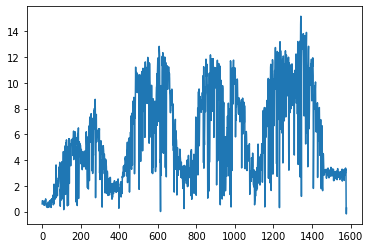

In [96]:
pd.read_csv('./train1.csv')['광진구'].plot()

<AxesSubplot:>

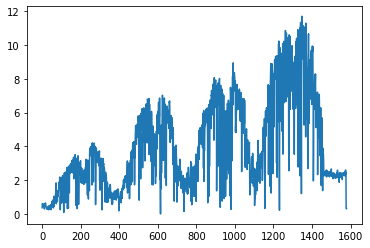

In [97]:
pd.read_csv('./train1.csv')['동대문구'].plot()

<AxesSubplot:>

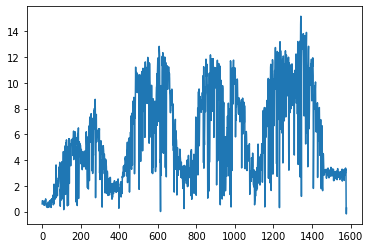

In [98]:
pd.read_csv('./train1.csv')['광진구'].plot()